In [39]:
from qiskit_algorithms.utils import algorithm_globals
from sklearn import datasets
from sklearn.model_selection import train_test_split
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap, ZFeatureMap, TwoLocal
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from sklearn.svm import SVC
from qiskit_machine_learning.algorithms import QSVC
import numpy as np
from matplotlib import pyplot as plt
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import BlueprintCircuit
from qiskit.circuit import Parameter
from sklearn.preprocessing import StandardScaler, MinMaxScaler

Create Iris training set and test set. Use 2 features and 2 classes to visualize better. 

In [27]:
algorithm_globals.random_seed = 13

class1 = 0
class2 = 1
feature1 = 0
feature2 = 1


iris = datasets.load_iris()

X = iris.data[:, [feature1, feature2]]
y = iris.target

X = X[np.logical_or(y == class1, y == class2)]
y = y[np.logical_or(y == class1, y == class2)]

feature_dimension = X.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=14)

std_scale = StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)
samples = np.append(X_train, X_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
X_train = minmax_scale.transform(X_train)
X_test = minmax_scale.transform(X_test)



Create feature map. We can use different feauture maps and this is what actually defines the kernel. 

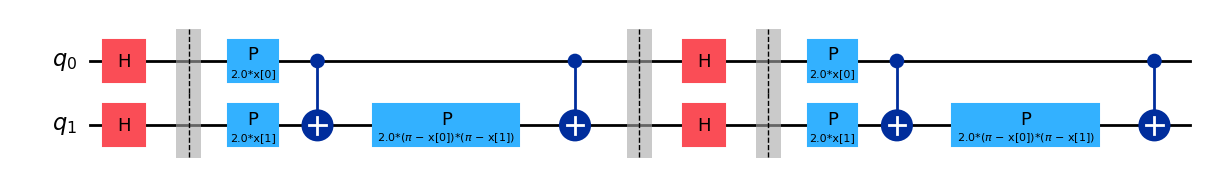

In [33]:
feature_map = ZZFeatureMap(feature_dimension=feature_dimension, reps=2, entanglement='linear', insert_barriers=True)
feature_map.decompose().draw('mpl')

Create Kernel and go back to classical sklearn. Train and plot accuracy on test set and decision boundary. 

Accuracy:  0.5666666666666667


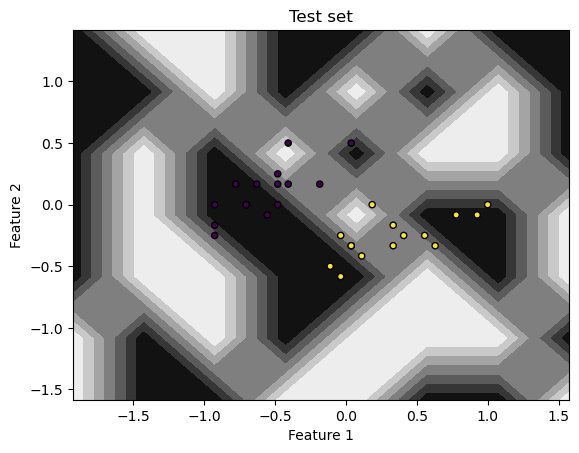

In [40]:
kernel = FidelityQuantumKernel(feature_map=feature_map)

svm = SVC(kernel=kernel.evaluate, C=1) 
svm.fit(X_train,y_train)

print('Accuracy: ', svm.score(X_test, y_test))

x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1

# Genera una griglia di punti per valutare il modello
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5), np.arange(y_min, y_max, 0.5))
Z = svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Disegna la decision boundary e i punti del test set
plt.contourf(xx, yy, Z, cmap='binary')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=20, edgecolor='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Test set')
plt.show()